In [3]:
# Cell 1: Imports and Data Loading
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("Original_Airbnb_Dataset.csv")
print("Original shape:", df.shape)
print(df.head())

Original shape: (18448, 26)
        id                                              NAME      host id  \
0  1001254                Clean & quiet apt home by the park  80014485718   
1  1002102                             Skylit Midtown Castle  52335172823   
2  1002403               THE VILLAGE OF HARLEM....NEW YORK !  78829239556   
3  1002755                                               NaN  85098326012   
4  1003689  Entire Apt: Spacious Studio/Loft by central park  92037596077   

  host_identity_verified host name neighbourhood group neighbourhood  \
0            unconfirmed  Madaline            Brooklyn    Kensington   
1               verified     Jenna           Manhattan       Midtown   
2                    NaN     Elise           Manhattan        Harlem   
3            unconfirmed     Garry            Brooklyn  Clinton Hill   
4               verified    Lyndon           Manhattan   East Harlem   

        lat      long        country  ... service fee minimum nights  \
0  4

In [4]:
# Cell 2: Basic Info, Column Dropping
df.info()

drop_cols = [
    'NAME', 'host name', 'neighbourhood', 'country code', 'license',
    'country', 'house_rules', 'service fee'
]
df.columns = [c.strip() for c in df.columns]
to_drop = [c for c in drop_cols if c in df.columns]
df = df.drop(columns=to_drop)
print(f"Dropped {len(to_drop)} columns:", to_drop)
print("Remaining columns:", list(df.columns))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18448 entries, 0 to 18447
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              18448 non-null  int64  
 1   NAME                            18372 non-null  object 
 2   host id                         18448 non-null  int64  
 3   host_identity_verified          18353 non-null  object 
 4   host name                       18409 non-null  object 
 5   neighbourhood group             18421 non-null  object 
 6   neighbourhood                   18432 non-null  object 
 7   lat                             18440 non-null  float64
 8   long                            18440 non-null  float64
 9   country                         18397 non-null  object 
 10  country code                    18368 non-null  object 
 11  instant_bookable                18368 non-null  object 
 12  cancellation_policy             

In [5]:
# Cell 3: Missing Value Check
print("\nMissing values before imputation:")
print(df.isnull().sum())


Missing values before imputation:
id                                   0
host id                              0
host_identity_verified              95
neighbourhood group                 27
lat                                  8
long                                 8
instant_bookable                    80
cancellation_policy                 51
room type                            1
Construction year                  147
price                               65
minimum nights                     161
number of reviews                   21
last review                       3201
reviews per month                 3187
review rate number                 104
calculated host listings count      61
availability 365                   159
dtype: int64


In [6]:
# Cell 4: Clean Price, Drop Critically Missing Targets/Locations
# Clean price column (remove $ and convert to float)
if 'price' in df.columns:
    df['price'] = (df['price'].astype(str)
                   .str.replace(r'[^0-9.\\-]', '', regex=True)
                   .replace('', np.nan)
                   .astype(float))

# Drop rows with missing price or lat/long (critical for modeling)
df = df.dropna(subset=['price'])
df = df.dropna(subset=['lat', 'long'])

# Convert last review to datetime
df['last review'] = pd.to_datetime(df['last review'], format='%m/%d/%Y', errors='coerce')
print(f"Shape after basic cleaning: {df.shape}")

Shape after basic cleaning: (18375, 18)


In [7]:
# Cell 5: Train-Test Split Before Statistical Preprocessing (No Leakage!)
from sklearn.model_selection import train_test_split

X = df.drop(['price'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Train shape: (14700, 17), Test shape: (3675, 17)


In [8]:
# Cell 6: Preprocessing Function (Apply Stats From Training Only)
def preprocess_data(X_train, X_test):
    X_train_proc, X_test_proc = X_train.copy(), X_test.copy()

    # Categorical columns - mode from TRAIN only, use 'unknown'/mode as required
    cat_cols = ['host_identity_verified', 'instant_bookable', 'cancellation_policy', 'room type', 'neighbourhood group']
    cat_modes = {col: X_train_proc[col].mode()[0] if col in X_train_proc else 'unknown' for col in cat_cols}

    for col in cat_cols:
        if col in X_train_proc:
            X_train_proc[col] = X_train_proc[col].fillna('unknown' if col in ['host_identity_verified', 'instant_bookable'] else cat_modes[col])
        if col in X_test_proc:
            X_test_proc[col] = X_test_proc[col].fillna('unknown' if col in ['host_identity_verified', 'instant_bookable'] else cat_modes[col])

    # If neighbourhood group is missing AND lat/long missing, drop row (in TRAIN and TEST separately)
    for subset, subset_proc in zip(['TRAIN', 'TEST'], [X_train_proc, X_test_proc]):
        missing_group = subset_proc['neighbourhood group'].isnull()
        missing_latlong = subset_proc['lat'].isnull() | subset_proc['long'].isnull()
        drop_mask = missing_group & missing_latlong
        subset_proc.drop(index=subset_proc[drop_mask].index, inplace=True)
        if 'neighbourhood group' in subset_proc:
            subset_proc['neighbourhood group'] = subset_proc['neighbourhood group'].fillna(cat_modes['neighbourhood group'])

    # Construction year - median by room type from TRAIN only, add indicator
    if 'Construction year' in X_train_proc:
        X_train_proc['is_construction_year_missing'] = X_train_proc['Construction year'].isnull().astype(int)
        X_test_proc['is_construction_year_missing'] = X_test_proc['Construction year'].isnull().astype(int)

        train_medians = X_train_proc.groupby('room type')['Construction year'].median()
        overall_median = X_train_proc['Construction year'].median()

        # Apply train medians
        for room_type in train_medians.index:
            mask = (X_train_proc['room type'] == room_type) & X_train_proc['Construction year'].isnull()
            X_train_proc.loc[mask, 'Construction year'] = train_medians[room_type]
        X_train_proc['Construction year'] = X_train_proc['Construction year'].fillna(overall_median)

        # Apply to test
        for room_type in train_medians.index:
            mask = (X_test_proc['room type'] == room_type) & X_test_proc['Construction year'].isnull()
            X_test_proc.loc[mask, 'Construction year'] = train_medians[room_type]
        X_test_proc['Construction year'] = X_test_proc['Construction year'].fillna(overall_median)

    # Minimum nights - median by room type from TRAIN only
    if 'minimum nights' in X_train_proc:
        train_medians = X_train_proc.groupby('room type')['minimum nights'].median()
        overall_median = X_train_proc['minimum nights'].median()

        for room_type in train_medians.index:
            mask = (X_train_proc['room type'] == room_type) & X_train_proc['minimum nights'].isnull()
            X_train_proc.loc[mask, 'minimum nights'] = train_medians[room_type]
        X_train_proc['minimum nights'] = X_train_proc['minimum nights'].fillna(overall_median)

        for room_type in train_medians.index:
            mask = (X_test_proc['room type'] == room_type) & X_test_proc['minimum nights'].isnull()
            X_test_proc.loc[mask, 'minimum nights'] = train_medians[room_type]
        X_test_proc['minimum nights'] = X_test_proc['minimum nights'].fillna(overall_median)

    # Number of reviews: Fill 0 if missing + missing indicator
    if 'number of reviews' in X_train_proc:
        X_train_proc['is_num_reviews_missing'] = X_train_proc['number of reviews'].isnull().astype(int)
        X_test_proc['is_num_reviews_missing'] = X_test_proc['number of reviews'].isnull().astype(int)
        X_train_proc['number of reviews'] = X_train_proc['number of reviews'].fillna(0)
        X_test_proc['number of reviews'] = X_test_proc['number of reviews'].fillna(0)

    # Last review (days since...) + missing indicator
    if 'last review' in X_train_proc:
        today = pd.Timestamp(datetime.now())
        X_train_proc['days_since_last_review'] = (today - X_train_proc['last review']).dt.days
        X_test_proc['days_since_last_review'] = (today - X_test_proc['last review']).dt.days

        train_max = X_train_proc['days_since_last_review'].max() if X_train_proc['days_since_last_review'].notna().any() else 999999
        sentinel = train_max + 1

        X_train_proc['days_since_last_review'] = X_train_proc['days_since_last_review'].fillna(sentinel).astype('int64')
        X_test_proc['days_since_last_review'] = X_test_proc['days_since_last_review'].fillna(sentinel).astype('int64')

        X_train_proc['is_last_review_missing'] = X_train_proc['last review'].isna().astype(int)
        X_test_proc['is_last_review_missing'] = X_test_proc['last review'].isna().astype(int)

    # Reviews per month: 0 if number of reviews is 0, else median by room type (TRAIN only)
    if 'reviews per month' in X_train_proc:
        X_train_proc.loc[X_train_proc['number of reviews'] == 0, 'reviews per month'] = 0
        X_test_proc.loc[X_test_proc['number of reviews'] == 0, 'reviews per month'] = 0

        train_medians = X_train_proc.groupby('room type')['reviews per month'].median()
        for room_type in train_medians.index:
            mask = (X_train_proc['room type'] == room_type) & X_train_proc['reviews per month'].isnull()
            X_train_proc.loc[mask, 'reviews per month'] = train_medians[room_type]

            mask2 = (X_test_proc['room type'] == room_type) & X_test_proc['reviews per month'].isnull()
            X_test_proc.loc[mask2, 'reviews per month'] = train_medians[room_type]

        X_train_proc['reviews per month'] = X_train_proc['reviews per month'].fillna(0)
        X_test_proc['reviews per month'] = X_test_proc['reviews per month'].fillna(0)

    # review rate number (median by room type TRAIN only)
    if 'review rate number' in X_train_proc:
        train_medians = X_train_proc.groupby('room type')['review rate number'].median()
        overall_median = X_train_proc['review rate number'].median()

        for room_type in train_medians.index:
            mask = (X_train_proc['room type'] == room_type) & X_train_proc['review rate number'].isnull()
            X_train_proc.loc[mask, 'review rate number'] = train_medians[room_type]

            mask2 = (X_test_proc['room type'] == room_type) & X_test_proc['review rate number'].isnull()
            X_test_proc.loc[mask2, 'review rate number'] = train_medians[room_type]

        X_train_proc['review rate number'] = X_train_proc['review rate number'].fillna(overall_median)
        X_test_proc['review rate number'] = X_test_proc['review rate number'].fillna(overall_median)

    # calculated host listings count (median from TRAIN)
    if 'calculated host listings count' in X_train_proc:
        overall_median = X_train_proc['calculated host listings count'].median()
        X_train_proc['calculated host listings count'] = X_train_proc['calculated host listings count'].fillna(overall_median)
        X_test_proc['calculated host listings count'] = X_test_proc['calculated host listings count'].fillna(overall_median)

    # availability 365 (median by room type TRAIN only)
    if 'availability 365' in X_train_proc:
        train_medians = X_train_proc.groupby('room type')['availability 365'].median()
        overall_median = X_train_proc['availability 365'].median()

        for room_type in train_medians.index:
            mask = (X_train_proc['room type'] == room_type) & X_train_proc['availability 365'].isnull()
            X_train_proc.loc[mask, 'availability 365'] = train_medians[room_type]

            mask2 = (X_test_proc['room type'] == room_type) & X_test_proc['availability 365'].isnull()
            X_test_proc.loc[mask2, 'availability 365'] = train_medians[room_type]

        X_train_proc['availability 365'] = X_train_proc['availability 365'].fillna(overall_median)
        X_test_proc['availability 365'] = X_test_proc['availability 365'].fillna(overall_median)

    # Feature engineering: property age, review density (no leakage)
    current_year = pd.Timestamp.today().year
    if 'Construction year' in X_train_proc:
        X_train_proc['property_age'] = current_year - X_train_proc['Construction year']
        X_test_proc['property_age'] = current_year - X_test_proc['Construction year']

    if 'number of reviews' in X_train_proc and 'days_since_last_review' in X_train_proc:
        X_train_proc['review_density'] = X_train_proc['number of reviews'] / (X_train_proc['days_since_last_review'] + 1)
        X_test_proc['review_density'] = X_test_proc['number of reviews'] / (X_test_proc['days_since_last_review'] + 1)

    # One-hot encoding for categoricals (fit ONLY on train, apply to both!)
    cat_encode = [col for col in cat_cols if col in X_train_proc]
    if cat_encode:
        train_dummies = pd.get_dummies(X_train_proc[cat_encode], drop_first=True)
        test_dummies = pd.get_dummies(X_test_proc[cat_encode], drop_first=True)

        # Align columns, fill missing columns with 0 for test
        test_dummies = test_dummies.reindex(columns=train_dummies.columns, fill_value=0)

        X_train_proc = pd.concat([X_train_proc.drop(columns=cat_encode), train_dummies], axis=1)
        X_test_proc = pd.concat([X_test_proc.drop(columns=cat_encode), test_dummies], axis=1)

    # Drop columns not required for ML
    cols_to_drop = ['last review', 'id', 'host id']
    X_train_proc = X_train_proc.drop(columns=[c for c in cols_to_drop if c in X_train_proc], errors='ignore')
    X_test_proc = X_test_proc.drop(columns=[c for c in cols_to_drop if c in X_test_proc], errors='ignore')

    # Final missing value report
    print("\nAfter preprocessing (TRAIN):", X_train_proc.isnull().sum().sum())
    print("After preprocessing (TEST):", X_test_proc.isnull().sum().sum())

    return X_train_proc, X_test_proc

X_train_processed, X_test_processed = preprocess_data(X_train, X_test)
y_train_processed = y_train.loc[X_train_processed.index]
y_test_processed = y_test.loc[X_test_processed.index]


After preprocessing (TRAIN): 0
After preprocessing (TEST): 0


In [9]:
# Cell 7: Combine Features/Target, Save CSVs
train_data = X_train_processed.copy()
train_data['price'] = y_train_processed
test_data = X_test_processed.copy()
test_data['price'] = y_test_processed

train_data.to_csv('train_data_no_leakage.csv', index=False)
test_data.to_csv('test_data_no_leakage.csv', index=False)

print(f"Saved train_data_no_leakage.csv: {train_data.shape}")
print(f"Saved test_data_no_leakage.csv: {test_data.shape}")

Saved train_data_no_leakage.csv: (14700, 30)
Saved test_data_no_leakage.csv: (3675, 30)


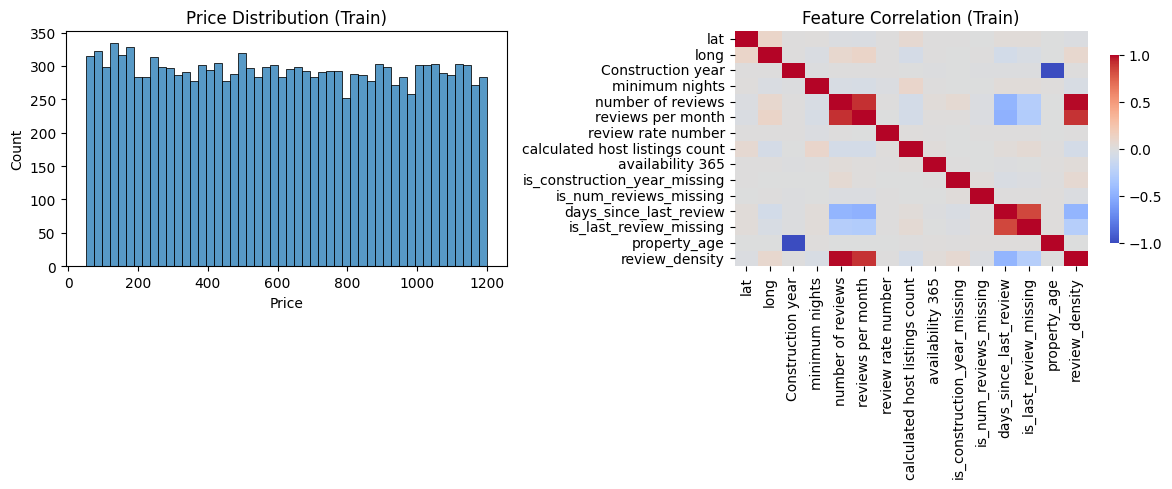

In [10]:
# Cell 8: Optional - Visualization (Training Set Only!)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(y_train_processed, bins=50)
plt.title('Price Distribution (Train)')
plt.xlabel('Price')
plt.subplot(1,2,2)
corr_data = X_train_processed.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr_data, cmap='coolwarm', center=0, cbar_kws={'shrink':0.8})
plt.title('Feature Correlation (Train)')
plt.tight_layout()
plt.show()

In [11]:
from google.colab import files
files.download('train_data_no_leakage.csv')
files.download('test_data_no_leakage.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>